## Data dependencies

In [1]:
lexical_stat_path = "../data/20.31-lexical-stat-df.csv"
pythia_exp_stats_path = "../data/32.20-pythia-exp-stats.csv"
cwn_comp_adv_path = "../data/34.20-cwn-comp-adv.csv"
!sha1sum $lexical_stat_path $pythia_exp_stats_path $cwn_comp_adv_path

16ed96e01a907e2865034224445ec115c07f7499  ../data/20.31-lexical-stat-df.csv
f6f4a4c61c2bbc579f0cb44e2e6b8f993e4cc0bb  ../data/32.20-pythia-exp-stats.csv
a4f8ba090207c6ab50e27b10bcbe1717035239dc  ../data/34.20-cwn-comp-adv.csv


## Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("paper", style="whitegrid")

In [3]:
lexical_stat_df = pd.read_csv(lexical_stat_path, header=[0,1,2], index_col=[0])
pythia_exp_stats_df = pd.read_csv(pythia_exp_stats_path)
cwn_comp_adv_df = pd.read_csv(cwn_comp_adv_path, header=[0], index_col=[0,1]).iloc[1:]

## Lexical completion statistics

In [4]:
lexstat_table = lexical_stat_df.loc[~lexical_stat_df.index.str.startswith("Llama"), :]
n_category = lexstat_table.loc[:, ("N")].iloc[0]
lexstat_table = lexstat_table.drop("N", axis=1, level=0)
lexstat_table
lex_paper_table = lexstat_table.loc[:, ("mean")].astype(object)
for model_name, row in lex_paper_table.iterrows():
  for col_name, value in row.items():
    se = lexstat_table.loc[model_name, ("se", *col_name)]
    lex_paper_table.loc[model_name, col_name] = f"{value:.4f} ({se:.4f})"

col_values = lex_paper_table.columns.values
for i, x in enumerate(col_values):
  n_item = n_category[x]
  pos = {"n": "Noun", "v": "Verb"}[x[1]]
  col_values[i] = (x[0].capitalize(), f"{pos} (N={n_item})")
lex_paper_table.index = lex_paper_table.index.str.capitalize()
lex_paper_table.columns = pd.MultiIndex.from_tuples(col_values)
lex_paper_table = lex_paper_table.iloc[[*list(range(2,lex_paper_table.shape[0])), 0, 1], :] # type: ignore


In [5]:
print(lex_paper_table.to_latex())

\begin{tabular}{llll}
\toprule
 & Holonym & \multicolumn{2}{r}{Hypernym} \\
 & Noun (N=164) & Noun (N=702) & Verb (N=583) \\
model &  &  &  \\
\midrule
Pythia-12b & 0.1157 (0.0174) & 0.5135 (0.0140) & 0.2760 (0.0131) \\
Pythia-6.9b & 0.1872 (0.0178) & 0.4623 (0.0144) & 0.3217 (0.0145) \\
Pythia-2.8b & 0.1524 (0.0188) & 0.4159 (0.0135) & 0.2501 (0.0122) \\
Pythia-1.4b & 0.0843 (0.0138) & 0.3092 (0.0147) & 0.1162 (0.0098) \\
Pythia-410m & 0.1034 (0.0148) & 0.1418 (0.0085) & 0.1202 (0.0094) \\
Gpt-3.5-turbo & 0.5039 (0.0316) & 0.6558 (0.0139) & 0.4963 (0.0142) \\
Gpt-3.5-turbo-instruct & 0.5411 (0.0346) & 0.5074 (0.0144) & 0.4655 (0.0139) \\
\bottomrule
\end{tabular}



## Pythia experiment

In [6]:
# update the "main" in ckpt_name to "step143000"
pythia_exp_stats_df.loc[pythia_exp_stats_df.ckpt_name == "main", "ckpt_name"] = "step143000"
rev_list = ["step143000", "step104000", "step65000", "step13000", "step7000", "step1"]
pythia_exp_stats_df = pythia_exp_stats_df.sort_values("ckpt_name", key=lambda x: x.map(rev_list.index), ascending=True)

In [7]:
pythia_exp_stats_df.head()

,model_name,ckpt_name,mean_comp,se_comp,nparam,mean_lprob,se_lprob
41,pythia-1.4b,step143000,0.082869,0.001799,1.400000e+09,0.632008,0.015555
35,pythia-70m,step143000,0.049141,0.001673,7.000000e+07,0.190942,0.018138
36,pythia-6.9b,step143000,0.098365,0.002082,6.900000e+09,0.774431,0.018611
40,pythia-12b,step143000,0.087883,0.001960,1.200000e+10,0.675444,0.018343
38,pythia-2.8b,step143000,0.082162,0.001811,2.800000e+09,0.607464,0.015724


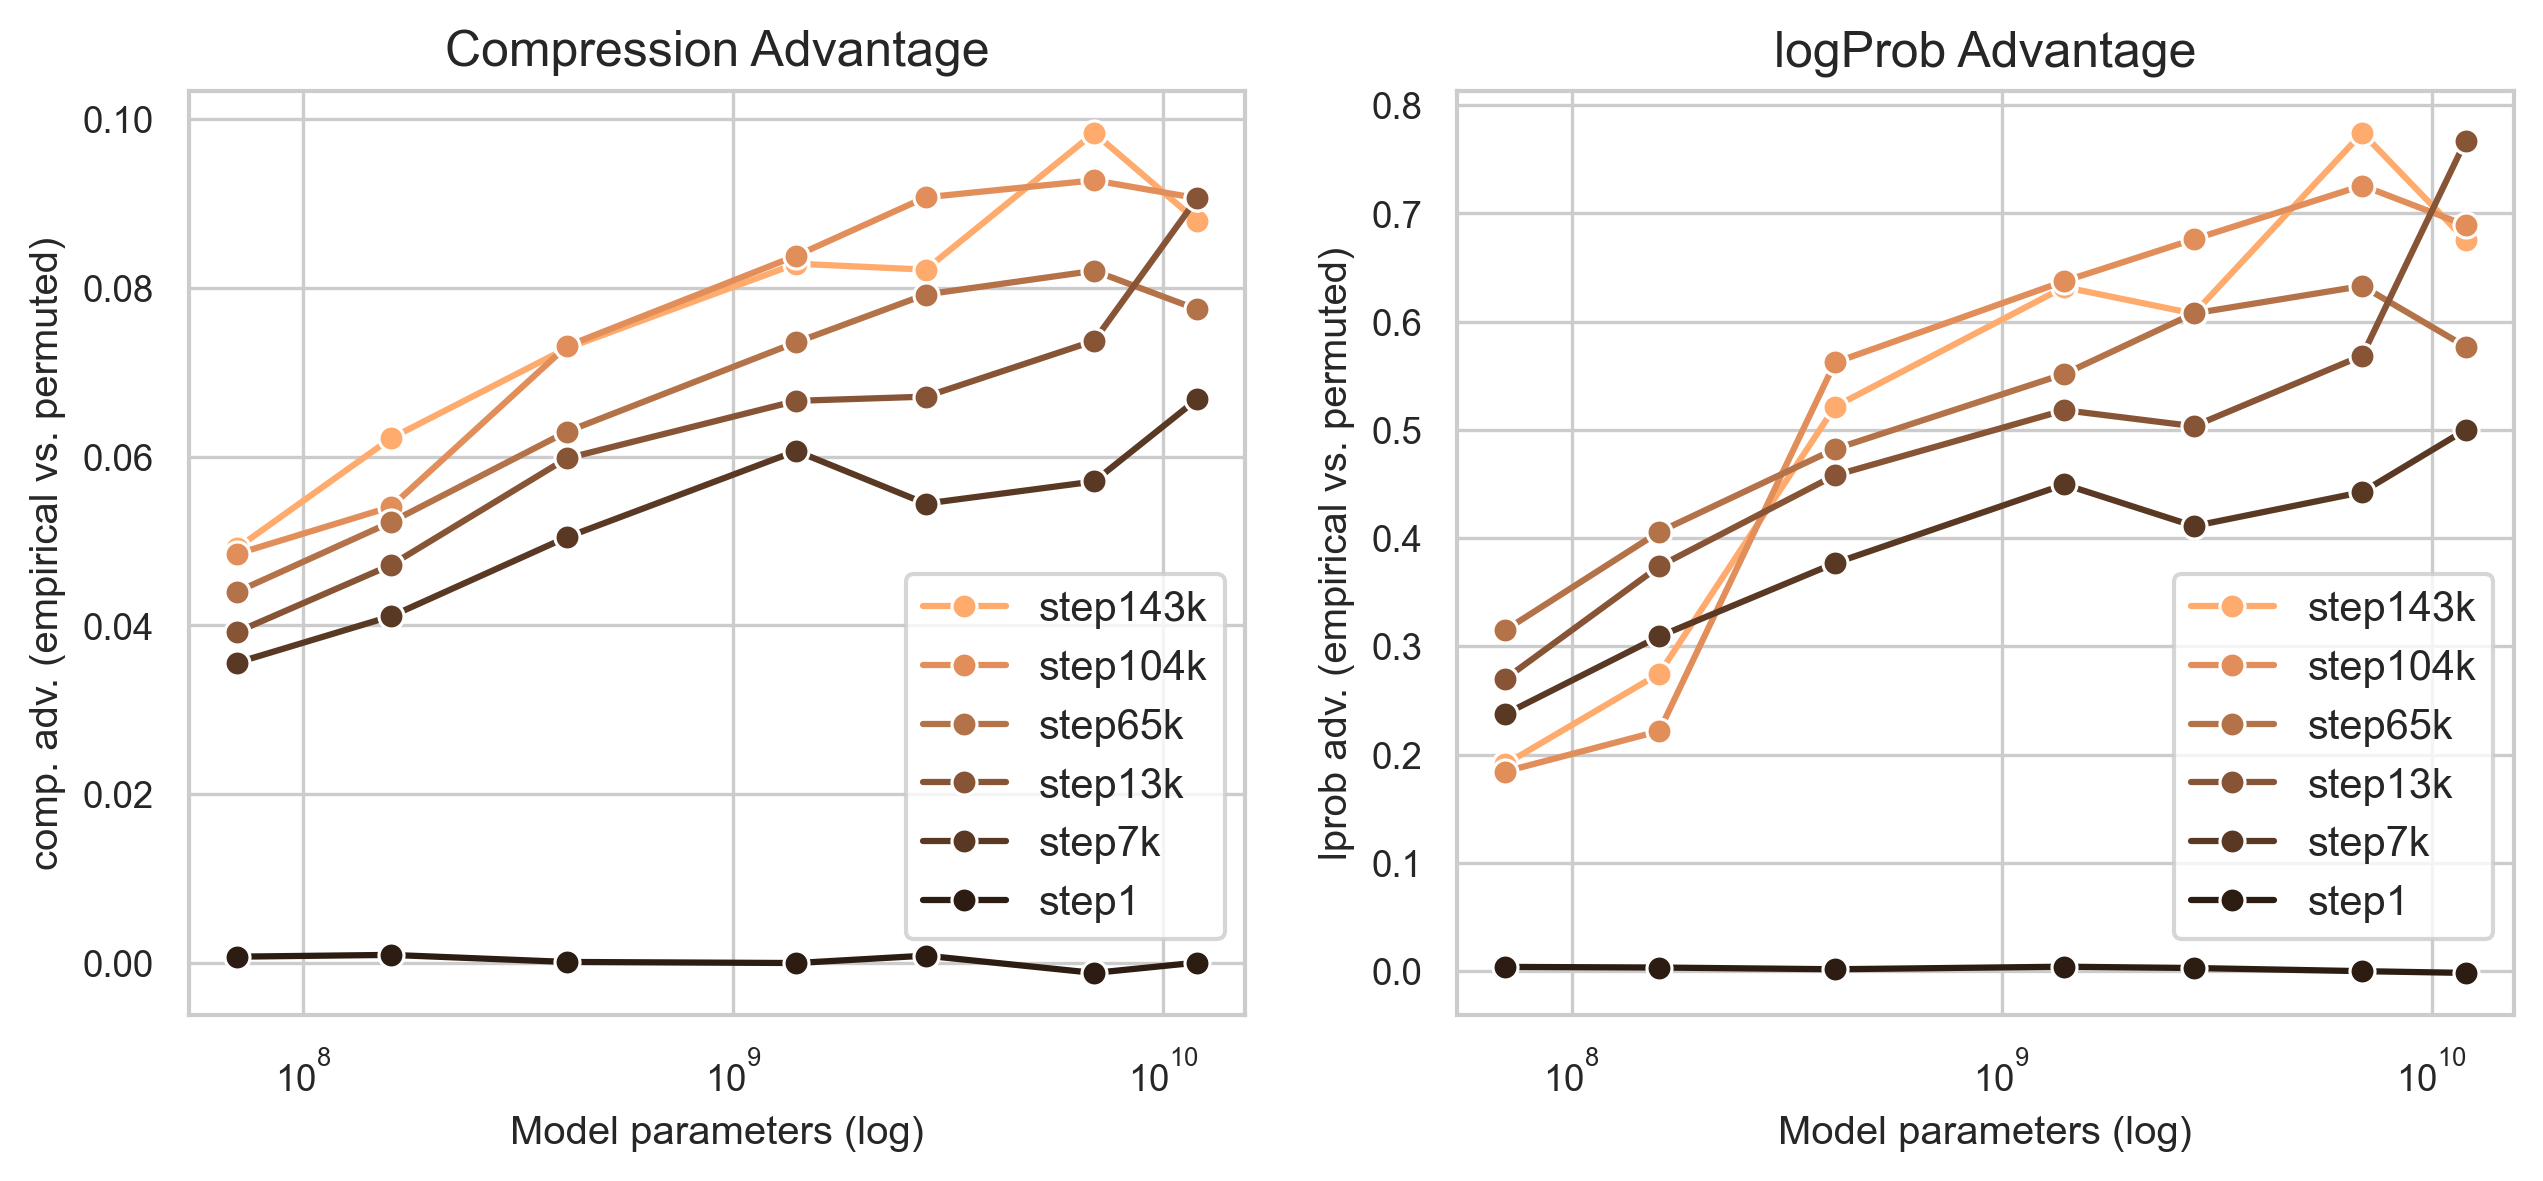

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
pythia_exp_stats_df["ckpt_name"] = pythia_exp_stats_df["ckpt_name"].str.replace("000", "k")
sns.set_theme(style="whitegrid")

# compression advantage
sns.lineplot(data=pythia_exp_stats_df, x="nparam", y="mean_comp", 
             hue="ckpt_name", marker="o", ax=axes[0], palette="copper_r")
axes[0].legend(loc="upper right", bbox_to_anchor=(1, 0.5), ncol=1, title="", fontsize=10)
axes[0].set_title("Compression Advantage")
axes[0].set_xscale("log")
axes[0].set_xlabel("Model parameters (log)")
axes[0].set_ylabel("comp. adv. (empirical vs. permuted)")

# lprob advantage
sns.lineplot(data=pythia_exp_stats_df, x="nparam", y="mean_lprob", 
             hue="ckpt_name", marker="o", ax=axes[1], palette="copper_r")
axes[1].legend(loc="upper right", bbox_to_anchor=(1, 0.5), ncol=1, title="", fontsize=10)
axes[1].set_title("logProb Advantage")
axes[1].set_xscale("log")
axes[1].set_xlabel("Model parameters (log)")
axes[1].set_ylabel("lprob adv. (empirical vs. permuted)")

fig.savefig("../data/figures/91.10-pythia-exp-stats.png", bbox_inches="tight")

## CWN experiment

In [9]:
cwn_comp_adv_df.value_counts(["model_name", "dataset"])
cwn_comp_adv_df = cwn_comp_adv_df.rename({
  "semrel": "CWN-semRel", 
  "eval": "Lollama-eval", 
  "lopegpt": "LopeGPT-RAG"
  }, level=1)

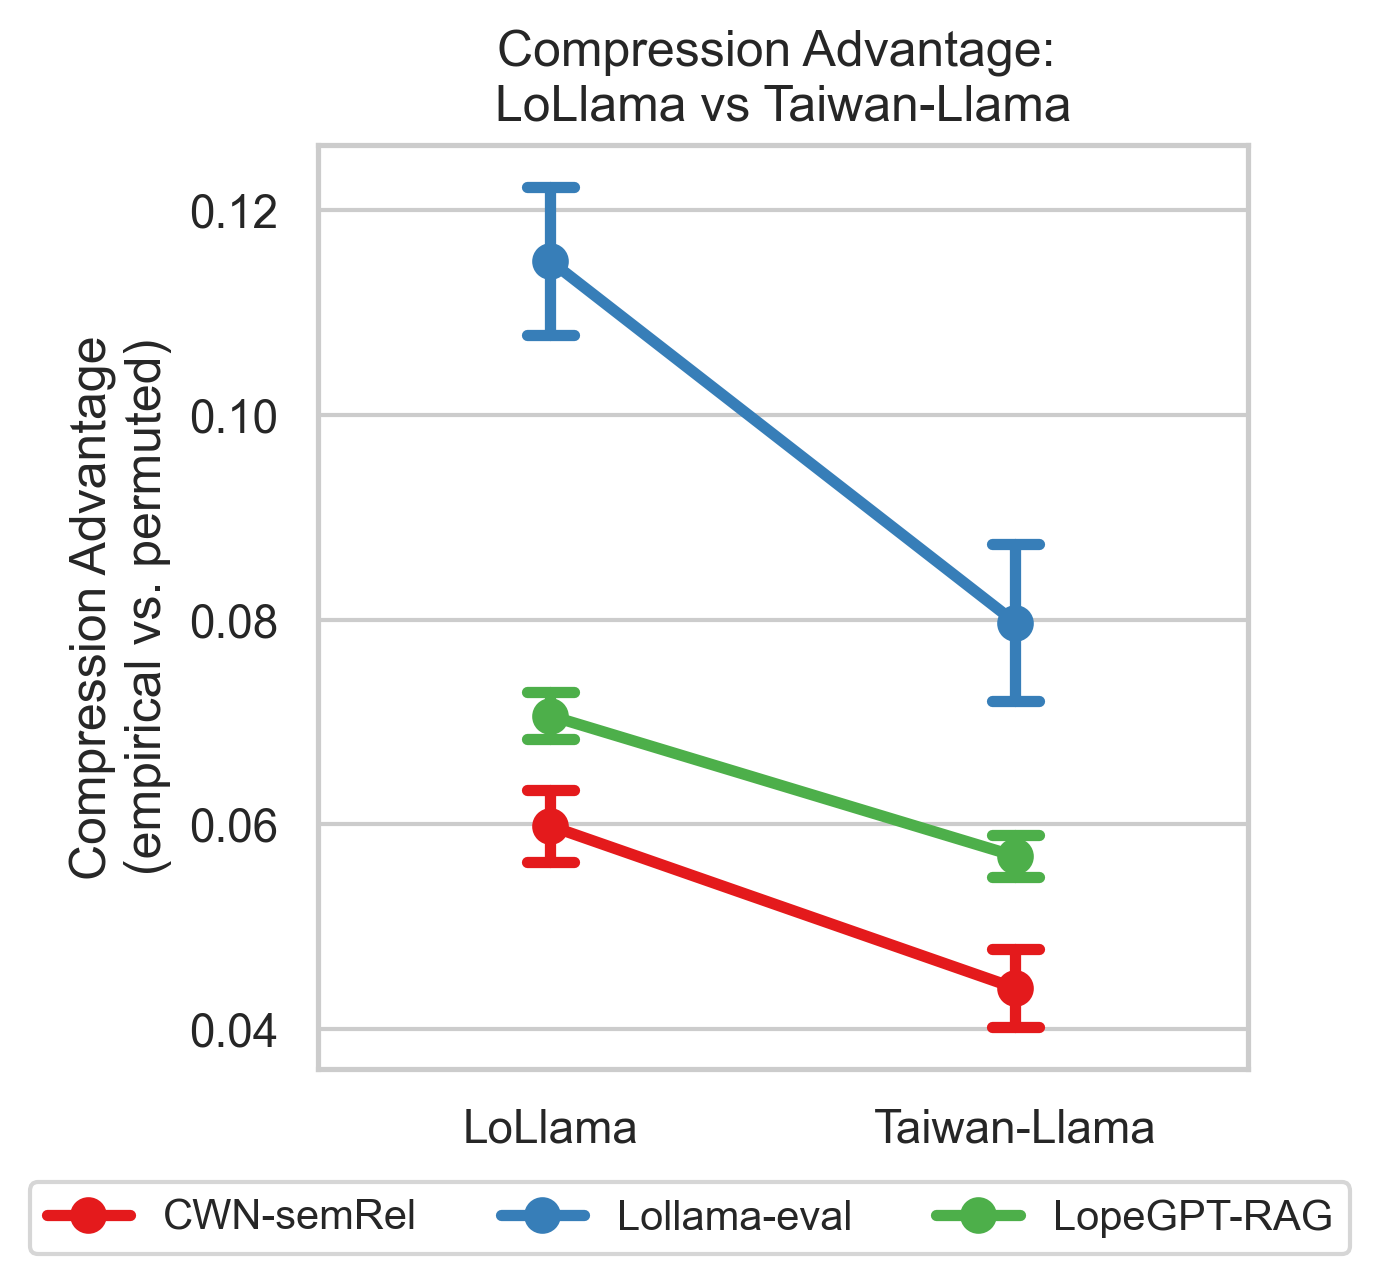

In [10]:
fig = plt.figure(figsize=(4, 4), dpi=300)
sns.pointplot(data=cwn_comp_adv_df, x="model_name", y="comp_adv", 
             hue="dataset", errorbar=('se',1), capsize=.1,
             palette="Set1")
plt.legend(loc="upper center", bbox_to_anchor=(0.4, -.1), ncol=3, title="", fontsize=10)
plt.title("Compression Advantage: \nLoLlama vs Taiwan-Llama")
plt.ylabel("Compression Advantage\n(empirical vs. permuted)")
plt.xlabel("")
fig.savefig("../data/figures/91.10-cwn-comp-adv.png", bbox_inches="tight")